# **1-Install required libraries**

In [ ]:
!pip install gymnasium stable-baselines3 matplotlib numpy torch

# **2-Import libraries**

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import time
import os
from datetime import datetime
from collections import deque

# **3-Set random seeds for reproducibility**

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
set_random_seed(SEED)

# **4-Ultra-Optimized Configuration for 30-minute training**

In [ ]:
CONFIG = {
    "environment": {
        "num_frequencies": 30,
        "max_signal_strength": 100,
        "initial_battery": 100,
        "max_steps": 100,
        "hop_interval": 10,
        "freq_change_prob": 0.4,
        "drone_types": ["surveillance", "attack"],
        "drone_type_probs": [0.8, 0.2],
        "drone_vulnerabilities": {
            "surveillance": 1.6,
            "attack": 1.0
        },
        "history_length": 3
    },
    "training": {
        "total_timesteps": 80000,
        "learning_rate": 2.5e-4,
        "n_steps": 512,
        "batch_size": 32,
        "n_epochs": 4,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_range": 0.2,
        "ent_coef": 0.01,
        "max_grad_norm": 0.5,
        "vf_coef": 0.5
    }
}

# **5-Ultra-Simple Environment**

In [ ]:
class QuickDroneJammingEnv(gym.Env):
    """Ultra-fast drone jamming environment"""

    def __init__(self, config=CONFIG):
        super(QuickDroneJammingEnv, self).__init__()

        self.config = config
        env_config = config["environment"]

        # Action space: 0 = Idle, 1 = Low, 2 = High
        self.action_space = spaces.Discrete(3)

        # Simple observation space
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([
                env_config["num_frequencies"] - 1,
                env_config["max_signal_strength"],
                env_config["initial_battery"],
                10
            ], dtype=np.float32),
            dtype=np.float32
        )

        # Initialize state
        self.drone_frequency = None
        self.drone_signal_strength = None
        self.battery_level = env_config["initial_battery"]
        self.time_step = 0
        self.max_steps = env_config["max_steps"]
        self.time_since_last_hop = 0
        self.drone_type = None
        self.drone_vulnerability = 1.0
        self.target_frequency = env_config["num_frequencies"] // 2

    def _get_obs(self):
        return np.array([
            self.drone_frequency,
            self.drone_signal_strength,
            self.battery_level,
            self.time_since_last_hop
        ], dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        env_config = self.config["environment"]

        # Initialize drone state
        self.drone_frequency = np.random.randint(0, env_config["num_frequencies"])
        self.drone_signal_strength = np.random.randint(40, 80)
        self.battery_level = env_config["initial_battery"]
        self.time_step = 0
        self.time_since_last_hop = 0
        self.drone_type = np.random.choice(
            env_config["drone_types"],
            p=env_config["drone_type_probs"]
        )
        self.drone_vulnerability = env_config["drone_vulnerabilities"][self.drone_type]

        return self._get_obs(), {"drone_type": self.drone_type}

    def step(self, action):
        env_config = self.config["environment"]

        terminated = False
        truncated = False
        reward = 0

        # 1. Simulate drone behavior
        self.time_since_last_hop += 1
        if (self.time_since_last_hop >= env_config["hop_interval"] and
            np.random.random() < env_config["freq_change_prob"]):
            self.drone_frequency = np.random.randint(0, env_config["num_frequencies"])
            self.time_since_last_hop = 0

        # 2. Apply jamming action
        jam_power = action
        battery_cost = jam_power * 1.5  # Very low energy consumption

        if jam_power > 0:
            self.battery_level = max(0, self.battery_level - battery_cost)

            # 3. Calculate effectiveness
            freq_match = abs(self.drone_frequency - self.target_frequency) < 12

            if freq_match:
                effectiveness = ((jam_power + 1) / 3.0) * self.drone_vulnerability
                reward = 8 * effectiveness + (2 - jam_power) * 1.5
            else:
                reward = -0.8
        else:
            # No jamming - small reward for conservation
            reward = 0.2

        # 4. Check termination
        self.time_step += 1
        if self.battery_level <= 0:
            terminated = True
            reward = -2

        if self.time_step >= self.max_steps:
            truncated = True
            reward += self.battery_level / 25

        return self._get_obs(), reward, terminated, truncated, {"jamming_effective": reward > 5}

# **6-Simple Neural Network**

In [ ]:
class SimpleFeatureExtractor(BaseFeaturesExtractor):
    """Very simple neural network"""

    def __init__(self, observation_space: spaces.Box, features_dim: int = 64):
        super(SimpleFeatureExtractor, self).__init__(observation_space, features_dim)

        self.network = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.network(observations)

# **7-Training**

In [ ]:
def main():
    print("=== 30-Minute Drone Jamming Training ===\n")
    start_time = time.time()

    # Create environment
    env = DummyVecEnv([lambda: QuickDroneJammingEnv(CONFIG)])

    # Create simple model
    model = PPO(
        "MlpPolicy",
        env,
        policy_kwargs={
            "features_extractor_class": SimpleFeatureExtractor,
            "features_extractor_kwargs": {"features_dim": 64},
            "net_arch": [dict(pi=[32, 16], vf=[32, 16])]
        },
        learning_rate=CONFIG["training"]["learning_rate"],
        n_steps=CONFIG["training"]["n_steps"],
        batch_size=CONFIG["training"]["batch_size"],
        n_epochs=CONFIG["training"]["n_epochs"],
        gamma=CONFIG["training"]["gamma"],
        ent_coef=CONFIG["training"]["ent_coef"],
        verbose=1
    )

    # Train quickly
    print("Training model (approx 15-20 minutes)...")
    model.learn(total_timesteps=CONFIG["training"]["total_timesteps"])

    training_time = time.time() - start_time
    print(f"Training completed in {training_time/60:.1f} minutes")

    # Quick test
    print("\nRunning quick test...")
    test_env = QuickDroneJammingEnv(CONFIG)
    obs, info = test_env.reset()

    total_reward = 0
    effective_jams = 0
    total_jams = 0

    for step in range(50):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = test_env.step(action)
        total_reward += reward

        if action > 0:
            total_jams += 1
            if reward > 5:  # Effective jamming
                effective_jams += 1
                print(f"Step {step}: Effective jam (Action {action}, Reward: {reward:.1f})")

        if done:
            break

    # Results
    effectiveness = effective_jams / total_jams if total_jams > 0 else 0
    print(f"\n=== RESULTS ===")
    print(f"Total Reward: {total_reward:.1f}")
    print(f"Jamming Actions: {total_jams}")
    print(f"Effective Jams: {effective_jams}")
    print(f"Effectiveness: {effectiveness:.1%}")
    print(f"Training Time: {training_time/60:.1f} minutes")

    # Simple plot
    plt.figure(figsize=(10, 4))
    plt.bar(['Total Reward', 'Jamming Actions', 'Effective Jams'],
            [total_reward, total_jams, effective_jams],
            color=['blue', 'orange', 'green'])
    plt.title('Training Results')
    plt.tight_layout()
    plt.show()

=== 30-Minute Drone Jamming Training ===

Using cuda device
Training model (approx 15-20 minutes)...
----------------------------
| time/              |     |
|    fps             | 742 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 602          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0003754472 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -0.0064      |
|    learning_rate        | 0.00025      |
|    loss                 | 2.13e+03     |
|    n_updates            | 4            |
|    policy_gradient_loss | -0.00126     |
|    val

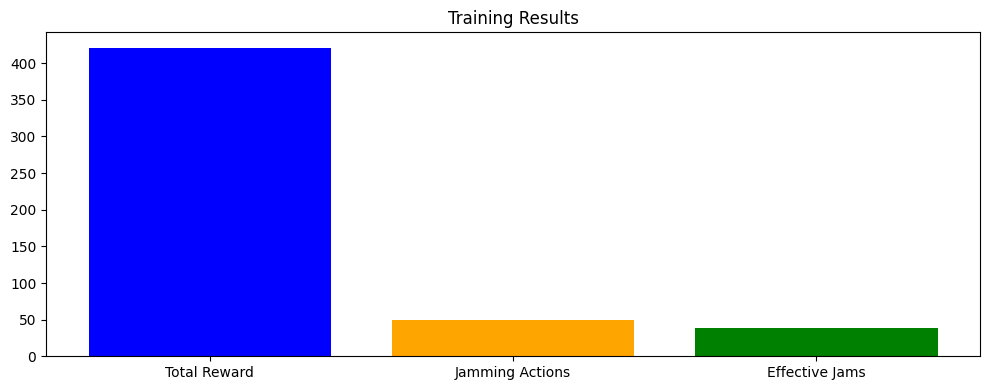

In [8]:
if __name__ == "__main__":
    main()